In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms


In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.data = torch.from_numpy(np.load(path)).float()

    def __getitem__(self, index):
        # normalise the data:
        self.data[index] = (self.data[index] - self.data[index].min()) / (self.data[index].max() - self.data[index].min())
        return self.data[index]

    def __len__(self):
        return len(self.data)

domain_A_dataset = MyDataset('../spectra-gan/noisy_data.npy')
domain_B_dataset = MyDataset('../spectra-gan/denoised_data.npy')
batch_size = 20

train_loader = DataLoader(domain_A_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(domain_B_dataset, batch_size=batch_size, shuffle=False)

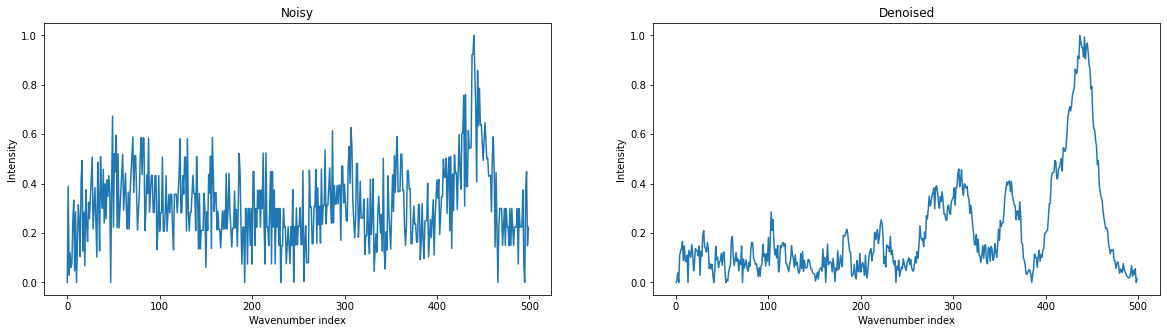

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))

# get one image from the batch
img = np.squeeze(images[0])
ax1.plot(img)

# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
ax2.plot(img)

# titles and labels
ax1.set_title('Noisy')
ax2.set_title('Denoised')
ax1.set_xlabel('Wavenumber index')
ax2.set_xlabel('Wavenumber index')
ax1.set_ylabel('Intensity')
ax2.set_ylabel('Intensity')
plt.show()


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers 
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv1d(in_channels = 32, out_channels = 16, kernel_size = 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv1d(in_channels = 16, out_channels = 8, kernel_size = 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool1d(2, 2)
        
        ## decoder layers 
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose1d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose1d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose1d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv1d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = self.pool(x)
        # add second hidden layer
        x = F.leaky_relu(self.conv2(x), 0.05)
        x = self.pool(x)
        # add third hidden layer
        x = F.leaky_relu(self.conv3(x), 0.05)
        x = self.pool(x)  # compressed representation
        
        ## decode
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = torch.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
# move model to GPU if available, by defining device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

ConvDenoiser(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose1d(8, 8, kernel_size=(3,), stride=(2,))
  (t_conv2): ConvTranspose1d(8, 16, kernel_size=(2,), stride=(2,))
  (t_conv3): ConvTranspose1d(16, 32, kernel_size=(2,), stride=(2,))
  (conv_out): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)


In [5]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# use a learning rate scheduler, since we have a validation loss function we can use that to decide when to decrease the learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)



In [6]:
# define a validation loss function to compare the MSE between the model-denoised spectra and the ground truth spectra:
def validation_loss(model, test_loader):
    test_loss = 0.0
    for data in test_loader:
        images = data
        # move tensors to GPU if CUDA is available
        images = images.to(device)
        # add extra dimension for the channel
        images = images.unsqueeze(1)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, images)
        # update running validation loss 
        test_loss += loss.item()*images.size(0)
            
    # print avg test loss 
    test_loss = test_loss/len(test_loader)
    return test_loss

In [8]:
# tas7ee7 min soolif

n_epochs = 15
training_losses = []
val_losses = []

for epoch in range(1, n_epochs+1):
    train_loss = 0.0

    for noisy, denoised in zip(train_loader, test_loader):
        noisy, denoised = noisy.to(device), denoised.to(device)
        images_noisy = noisy.unsqueeze(1)
        images_clean = denoised.unsqueeze(1)
                  
        optimizer.zero_grad()
        outputs = model(images_noisy)
        loss = criterion(outputs, images_clean)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images_noisy.size(0)

    train_loss = train_loss / len(train_loader)
    training_losses.append(train_loss)

    with torch.no_grad():
        val_loss = validation_loss(model, test_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

    print(f'Epoch: {epoch} | Training Loss: {train_loss:.6f} | Validation Loss: {val_loss:.6f}')

    torch.save(model.state_dict(), f'./checkpoints/spectra_dae_epoch_{epoch}.pth')


Epoch: 1 | Training Loss: 0.210482 | Validation Loss: 0.134896
Epoch: 2 | Training Loss: 0.183083 | Validation Loss: 0.141648
Epoch: 3 | Training Loss: 0.178158 | Validation Loss: 0.142821
Epoch: 4 | Training Loss: 0.175568 | Validation Loss: 0.145693
Epoch: 5 | Training Loss: 0.174160 | Validation Loss: 0.143357
Epoch: 6 | Training Loss: 0.173318 | Validation Loss: 0.143933
Epoch: 7 | Training Loss: 0.172746 | Validation Loss: 0.143904
Epoch: 8 | Training Loss: 0.171283 | Validation Loss: 0.116715
Epoch: 9 | Training Loss: 0.170441 | Validation Loss: 0.116729
Epoch: 10 | Training Loss: 0.170314 | Validation Loss: 0.116812
Epoch: 11 | Training Loss: 0.170216 | Validation Loss: 0.116976
Epoch: 12 | Training Loss: 0.170130 | Validation Loss: 0.117121
Epoch: 13 | Training Loss: 0.170051 | Validation Loss: 0.117184
Epoch: 14 | Training Loss: 0.169980 | Validation Loss: 0.117322
Epoch: 15 | Training Loss: 0.171399 | Validation Loss: 0.067696


In [9]:
# # number of epochs to train the model
# n_epochs = 15


# training_losses = []
# test_losses = []

# for epoch in range(1, n_epochs+1):
#     # monitor training loss
#     train_loss = 0.0
    
#     ###################
#     # train the model #
#     ###################
#     for noisy, denoised in zip(train_loader, test_loader):
#         # move tensors to GPU if CUDA is available
#         noisy, denoised = noisy.to(device), denoised.to(device)
        
#         images_noisy = noisy.unsqueeze(1)  # add a channel dimension
#         images_clean = denoised.unsqueeze(1)  # add a channel dimension
                  
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()

#         ## forward pass: compute predicted outputs by passing *noisy* images to the model
#         outputs = model(images_noisy)
#         # calculate the loss
#         loss = criterion(outputs, images_clean)
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()

#         # update running training loss
#         train_loss += loss.item()*images_noisy.size(0)

#         # get some validation losses so we can pass to lr scheduler:
#         with torch.no_grad():
#             test_loss = validation_loss(model, test_loader)
#             test_losses.append(test_loss)
#             scheduler.step(test_loss)

#     # print avg training statistics
#     train_loss = train_loss/len(train_loader)
#     # test loss already avg-d in the validation_loss function
#     training_losses.append(train_loss)

#     print(f'Epoch: {epoch} | Training Loss: {train_loss:.6f} | Validation Loss: {test_loss:.6f}')
    
#     # save model checkpoints every epoch
#     torch.save(model.state_dict(), f'./checkpoints/spectra_dae_epoch_{epoch}.pth')


In [ ]:

    #     # get some validation losses so we can pass to lr scheduler:
    #     with torch.no_grad():
    #         test_loss = validation_loss(model, test_loader)
    #         test_losses.append(test_loss)

    #     # reduce learning rate if validation loss plateaus
    #     scheduler.step(test_loss)
        

    # # print avg training statistics 
    # train_loss = train_loss/len(train_loader)
    # training_losses.append(train_loss)

    # # test loss already calculated in the validation_loss function

    # print(f'Epoch: {epoch} | Training Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}')
    # # save a checkpoint every epoch:
    # torch.save(model.state_dict(), f'./checkpoints/spectra_dae_epoch_{epoch}.pth')

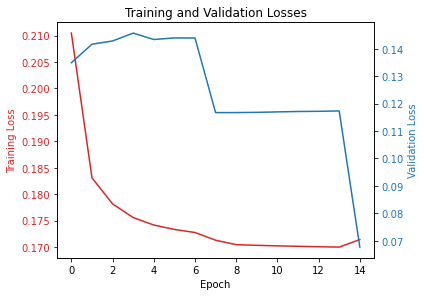

In [11]:
# plot the training and validation losses with separate y axes on the same plot:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(training_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(val_losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training and Validation Losses')
plt.show()



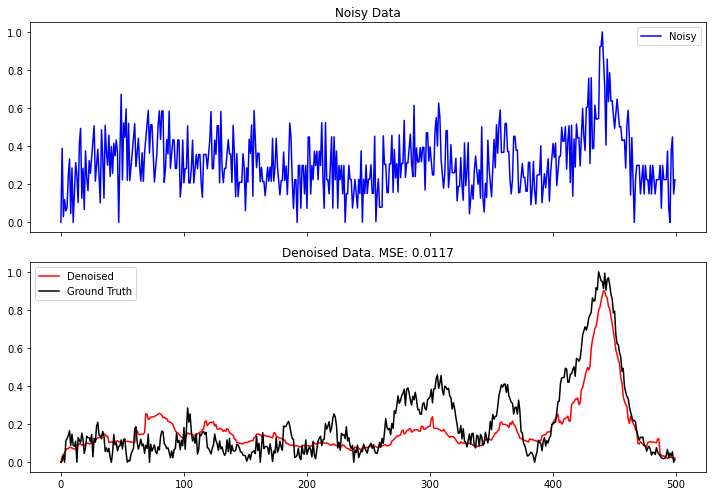

In [16]:
dataiter_noisy = iter(train_loader)
images_noisy = dataiter_noisy.next()

dataiter_clean = iter(test_loader)
images_clean = dataiter_clean.next()

# add an extra dimension for the channel
images_noisy = images_noisy.unsqueeze(1)
images_clean = images_clean.unsqueeze(1)

# insert the noisy images to the model and obtain denoised images
output_model = model(images_noisy.to(device))
# return one sample of denoised data
output_model = output_model.cpu().detach().numpy()

# plot the noisy and denoised data
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,7))


# compute the mse for a single sample between the model output and the ground truth
mse = ((images_clean[0].numpy() - output_model[0][0])**2).mean()

# plot the noisy data
axes[0].plot(images_noisy[0][0].cpu().detach().numpy(), color='b', label='Noisy')
axes[0].set_title('Noisy Data')
axes[0].legend()

# plot the denoised data
axes[1].plot(output_model[0][0], color='r', label='Denoised')
# add the ground truth data
axes[1].plot(images_clean[0][0].numpy(), color='k', label='Ground Truth')
axes[1].legend()
# annotate with the MSE between the two spectra
axes[1].set_title(f'Denoised Data. MSE: {mse:.4f}')

fig.tight_layout()
plt.show()


# # plot the noisy data
# axes[0].plot(images_noisy[0].numpy())

# # plot the denoised data
# axes[1].plot(output_model[0], label='Predicted')

# # plot the clean data
# axes[1].plot(images_clean[0].numpy(), label='Ground Truth')

# # annotate with the MSE between the two
# mse = ((images_clean[0].numpy() - output_model[0])**2).mean()

# # set titles
# axes[0].set_title('Noisy data')
# axes[1].set_title(f'Denoised data. MSE: {mse:.4f}')

# # label axes
# axes[0].set_ylabel('Intensity')
# axes[1].set_ylabel('Intensity')
# axes[1].set_xlabel('Wavenumber index')

In [23]:
# loop over the entire dataset and compare the MSE between the denoised (from the model) and the clean data:
mse = 0
all_mse = []
for noisy, clean in zip(train_loader, test_loader):
    images_noisy = noisy.unsqueeze(1)  # add a channel dimension
    images_clean = clean.unsqueeze(1)  # add a channel dimension

    # move tensors to GPU if CUDA is available
    images_noisy = images_noisy.to(device)
    images_clean = images_clean.to(device)

    # insert the noisy images to the model and obtain denoised images
    output_model = model(images_noisy)
    
    # return to cpu:
    images_clean = images_clean.cpu().detach().numpy()
    output_model = output_model.cpu().detach().numpy()

    # compute the mse for all samples in the batch and append to a list:
    for i in range(len(images_clean)):
        mse = ((images_clean[i][0] - output_model[i][0])**2).mean()
        all_mse.append(mse)

# compute the mean of the MSEs and std:
mean_mse = np.mean(all_mse)
std_mse = np.std(all_mse)

print(f'Mean MSE: {mean_mse:.4f} | Std MSE: {std_mse:.4f}')



Mean MSE: 0.0091 | Std MSE: 0.0088
